## Number Recognition

Handwritten digit recognition system not only detects scanned images of handwritten digits.Handwritten digit recognition using MNIST dataset is a major project made with the help of Neural Network. It basically detects the scanned images of handwritten digits.


Importing key libraries, and reading data

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1212)

import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import *
from keras import optimizers

D:\AI_ML\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# PREPARE DATA FOR NEURAL NETWORK
Y_train = df_train["label"]
X_train = df_train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = df_test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

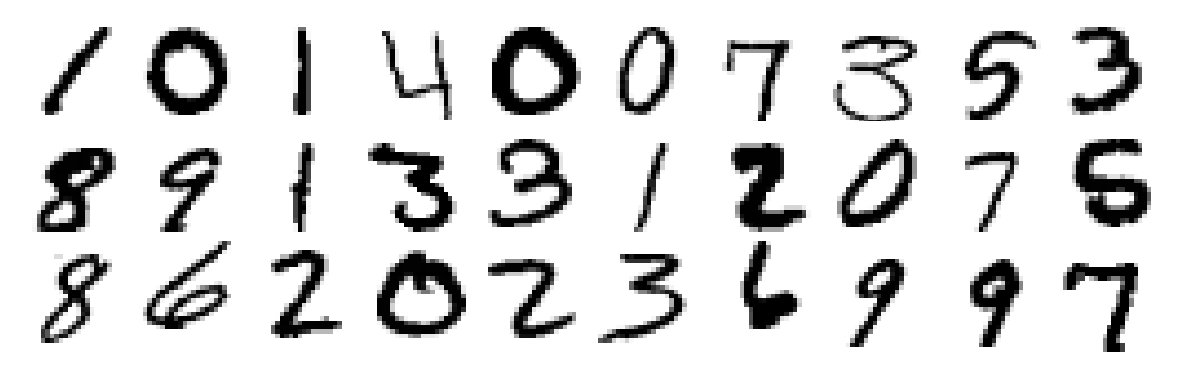

In [4]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [5]:
df_train.head() # 784 features, 1 label

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting into training and validation dataset

In [6]:
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

X_test = df_test.iloc[:, 0:784]

print(X_test.shape)

(28000, 784)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_features, df_label, 
                                                test_size = 0.2,
                                                random_state = 1212)

X_train = X_train.values.reshape(33600, 784) #(33600, 784)
X_cv = X_cv.values.reshape(8400, 784) #(8400, 784)

X_test = X_test.values.reshape(28000, 784)

## Data cleaning, normalization and selection

In [8]:
print((min(X_train[1]), max(X_train[1])))

(0, 255)


As the pixel intensities are currently between the range of 0 and 255, we proceed to normalize the features, using broadcasting. In addition, we proceed to convert our labels from a class vector to binary One Hot Encoded

In [9]:
# Feature Normalization 
X_train = X_train.astype('float32'); X_cv= X_cv.astype('float32'); X_test = X_test.astype('float32')
X_train /= 255; X_cv /= 255; X_test /= 255

# Convert labels to One Hot Encoded
num_digits = 10
y_train = keras.utils.to_categorical(y_train, num_digits)
y_cv = keras.utils.to_categorical(y_cv, num_digits)

In [10]:
# Printing 2 examples of labels after conversion
print(y_train[0]) # 2
print(y_train[3]) # 7

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Model Fitting

Model 1: Simple Neural Network with 4 layers (300, 100, 100, 200)

In our first model, we will use the Keras library to train a neural network with the activation function set as ReLu. To determine which class to output, we will rely on the SoftMax function

In [11]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [12]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [13]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model = Model(Inp, output)
model.summary() # We have 297,910 parameters to estimate

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 300)               235500    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 100)               30100     
                                                                 
 Hidden_Layer_3 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_Layer_4 (Dense)      (None, 200)               20200     
                                                                 
 Output_Layer (Dense)        (None, 10)                2010      
                                                                 
Total params: 297910 (1.14 MB)
Trainable params: 297910 (1.14

In [14]:
# Insert Hyperparameters
learning_rate = 0.1
training_epochs = 20
batch_size = 100
sgd = optimizers.SGD(lr=learning_rate)

In [15]:
# We rely on the plain vanilla Stochastic Gradient Descent as our optimizing methodology
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [16]:
history1 = model.fit(X_train, y_train,
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 - 4s - loss: 1.8452 - accuracy: 0.4704 - val_loss: 0.9932 - val_accuracy: 0.7792 - 4s/epoch - 12ms/step
Epoch 2/20
336/336 - 3s - loss: 0.6285 - accuracy: 0.8360 - val_loss: 0.4508 - val_accuracy: 0.8749 - 3s/epoch - 8ms/step
Epoch 3/20
336/336 - 3s - loss: 0.4046 - accuracy: 0.8851 - val_loss: 0.3553 - val_accuracy: 0.8957 - 3s/epoch - 10ms/step
Epoch 4/20
336/336 - 3s - loss: 0.3378 - accuracy: 0.9011 - val_loss: 0.3198 - val_accuracy: 0.9068 - 3s/epoch - 8ms/step
Epoch 5/20
336/336 - 2s - loss: 0.2997 - accuracy: 0.9121 - val_loss: 0.2880 - val_accuracy: 0.9182 - 2s/epoch - 7ms/step
Epoch 6/20
336/336 - 2s - loss: 0.2706 - accuracy: 0.9190 - val_loss: 0.2627 - val_accuracy: 0.9229 - 2s/epoch - 5ms/step
Epoch 7/20
336/336 - 4s - loss: 0.2478 - accuracy: 0.9266 - val_loss: 0.2489 - val_accuracy: 0.9271 - 4s/epoch - 11ms/step
Epoch 8/20
336/336 - 2s - loss: 0.2290 - accuracy: 0.9314 - val_loss: 0.2317 - val_accuracy: 0.9356 - 2s/epoch - 7ms/step
Epoch 9/20
336/336 - 

Using a 4 layer neural network with:

1. 20 training epochs
2. A training batch size of 100
3. Hidden layers set as (300, 100, 100, 200)
4. Learning rate of 0.1

Achieved a training score of around 96-98% and a test score of around 95 - 97%.

In [17]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

# We rely on ADAM as our optimizing methodology
adam = keras.optimizers.Adam(lr=learning_rate)
model2 = Model(Inp, output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
history2 = model2.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      verbose = 2,
                      validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 - 5s - loss: 0.3411 - accuracy: 0.8999 - val_loss: 0.1608 - val_accuracy: 0.9545 - 5s/epoch - 14ms/step
Epoch 2/20
336/336 - 4s - loss: 0.1211 - accuracy: 0.9626 - val_loss: 0.1173 - val_accuracy: 0.9656 - 4s/epoch - 12ms/step
Epoch 3/20
336/336 - 4s - loss: 0.0774 - accuracy: 0.9752 - val_loss: 0.1039 - val_accuracy: 0.9677 - 4s/epoch - 11ms/step
Epoch 4/20
336/336 - 4s - loss: 0.0557 - accuracy: 0.9819 - val_loss: 0.1120 - val_accuracy: 0.9680 - 4s/epoch - 12ms/step
Epoch 5/20
336/336 - 5s - loss: 0.0463 - accuracy: 0.9850 - val_loss: 0.0870 - val_accuracy: 0.9750 - 5s/epoch - 13ms/step
Epoch 6/20
336/336 - 4s - loss: 0.0328 - accuracy: 0.9885 - val_loss: 0.1017 - val_accuracy: 0.9736 - 4s/epoch - 13ms/step
Epoch 7/20
336/336 - 5s - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0958 - val_accuracy: 0.9752 - 5s/epoch - 16ms/step
Epoch 8/20
336/336 - 6s - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0994 - val_accuracy: 0.9750 - 6s/epoch - 17ms/step
Epoch 9/20
336/3

As it turns out, it does appear to be the case that the optimizer plays a crucial part in the validation score. In particular, the model which relies on 'Adam' as its optimizer tend to perform 1.5 - 2.5% better on average. Going forward, we will use 'Adam' as our optimizer of choice.

What if we changed the learning rate from 0.1 to 0.01, or 0.5? Will it have any impact on the accuracy?
Model 2A

In [19]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.01
adam = keras.optimizers.Adam(lr=learning_rate)
model2a = Model(Inp, output)

model2a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
history2a = model2a.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                        verbose = 2,
                        validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 - 5s - loss: 0.3428 - accuracy: 0.8998 - val_loss: 0.1711 - val_accuracy: 0.9480 - 5s/epoch - 16ms/step
Epoch 2/20
336/336 - 4s - loss: 0.1252 - accuracy: 0.9622 - val_loss: 0.1186 - val_accuracy: 0.9639 - 4s/epoch - 11ms/step
Epoch 3/20
336/336 - 4s - loss: 0.0854 - accuracy: 0.9729 - val_loss: 0.1027 - val_accuracy: 0.9704 - 4s/epoch - 11ms/step
Epoch 4/20
336/336 - 4s - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.0980 - val_accuracy: 0.9714 - 4s/epoch - 12ms/step
Epoch 5/20
336/336 - 4s - loss: 0.0451 - accuracy: 0.9857 - val_loss: 0.0992 - val_accuracy: 0.9729 - 4s/epoch - 11ms/step
Epoch 6/20
336/336 - 3s - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0920 - val_accuracy: 0.9736 - 3s/epoch - 10ms/step
Epoch 7/20
336/336 - 4s - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.1020 - val_accuracy: 0.9732 - 4s/epoch - 12ms/step
Epoch 8/20
336/336 - 5s - loss: 0.0277 - accuracy: 0.9914 - val_loss: 0.0979 - val_accuracy: 0.9751 - 5s/epoch - 14ms/step
Epoch 9/20
336/3

Model 2B

In [21]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.5
adam = keras.optimizers.Adam(lr=learning_rate)
model2b = Model(Inp, output)

model2b.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
history2b = model2b.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                            validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 [==============================] - 5s 12ms/step - loss: 0.3305 - accuracy: 0.9027 - val_loss: 0.1535 - val_accuracy: 0.9526
Epoch 2/20
336/336 [==============================] - 4s 12ms/step - loss: 0.1216 - accuracy: 0.9625 - val_loss: 0.1160 - val_accuracy: 0.9646
Epoch 3/20
336/336 [==============================] - 4s 12ms/step - loss: 0.0826 - accuracy: 0.9742 - val_loss: 0.0917 - val_accuracy: 0.9727
Epoch 4/20
336/336 [==============================] - 4s 12ms/step - loss: 0.0580 - accuracy: 0.9815 - val_loss: 0.0968 - val_accuracy: 0.9726
Epoch 5/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.1141 - val_accuracy: 0.9671
Epoch 6/20
336/336 [==============================] - 4s 12ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.1002 - val_accuracy: 0.9749
Epoch 7/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0307 - accuracy: 0.9901 - val_loss: 0.1001 - val_accuracy: 0.9720

The accuracy, as measured by the 3 different learning rates 0.01, 0.1 and 0.5 are around 98%, 97% and 98% respectively. As there are no considerable gains by changing the learning rates, we stick with the default learning rate of 0.01.

We proceed to fit a neural network with 5 hidden layers with the features in the hidden layer set as (300, 100, 100, 100, 200) respectively. To ensure that the two models are comparable, we will set the training epochs as 20, and the training batch size as 100.

In [23]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 100
n_hidden_5 = 200
num_digits = 10

In [24]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
x = Dense(n_hidden_5, activation='relu', name = "Hidden_Layer_5")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [25]:
# Our model would have '7' layers - input layer, 5 hidden layer and 1 output layer
model3 = Model(Inp, output)
model3.summary() # We have 308,010 parameters to estimate

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 300)               235500    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 100)               30100     
                                                                 
 Hidden_Layer_3 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_Layer_4 (Dense)      (None, 100)               10100     
                                                                 
 Hidden_Layer_5 (Dense)      (None, 200)               20200     
                                                                 
 Output_Layer (Dense)        (None, 10)                2010

In [26]:
# We rely on 'Adam' as our optimizing methodology
adam = keras.optimizers.Adam(lr=0.01)

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history3 = model3.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 [==============================] - 6s 15ms/step - loss: 0.3620 - accuracy: 0.8921 - val_loss: 0.1664 - val_accuracy: 0.9479
Epoch 2/20
336/336 [==============================] - 4s 13ms/step - loss: 0.1231 - accuracy: 0.9623 - val_loss: 0.1223 - val_accuracy: 0.9618
Epoch 3/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0838 - accuracy: 0.9733 - val_loss: 0.1313 - val_accuracy: 0.9638
Epoch 4/20
336/336 [==============================] - 5s 13ms/step - loss: 0.0630 - accuracy: 0.9795 - val_loss: 0.0959 - val_accuracy: 0.9701
Epoch 5/20
336/336 [==============================] - 5s 15ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.1074 - val_accuracy: 0.9695
Epoch 6/20
336/336 [==============================] - 4s 13ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0844 - val_accuracy: 0.9769
Epoch 7/20
336/336 [==============================] - 5s 14ms/step - loss: 0.0338 - accuracy: 0.9897 - val_loss: 0.1439 - val_accuracy: 0.9639

Compared to our first model, adding an additional layer did not significantly improve the accuracy from our previous model. However, there are computational costs (in terms of complexity) in implementing an additional layer in our neural network. Given that the benefits of an additional layer are low while the costs are high, we will stick with the 4 layer neural network.

We now proceed to include dropout (dropout rate of 0.3) in our second model to prevent overfitting.

In [28]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [29]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dropout(0.3)(x)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [30]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model4 = Model(Inp, output)
model4.summary() # We have 297,910 parameters to estimate

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 Hidden_Layer_3 (Dense)      (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0   

In [31]:
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
history = model4.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = training_epochs,
                    validation_data=(X_cv, y_cv))

Epoch 1/20
336/336 [==============================] - 9s 23ms/step - loss: 0.5839 - accuracy: 0.8125 - val_loss: 0.1982 - val_accuracy: 0.9440
Epoch 2/20
336/336 [==============================] - 7s 22ms/step - loss: 0.2357 - accuracy: 0.9306 - val_loss: 0.1400 - val_accuracy: 0.9600
Epoch 3/20
336/336 [==============================] - 7s 21ms/step - loss: 0.1722 - accuracy: 0.9496 - val_loss: 0.1165 - val_accuracy: 0.9676
Epoch 4/20
336/336 [==============================] - 7s 22ms/step - loss: 0.1372 - accuracy: 0.9595 - val_loss: 0.1107 - val_accuracy: 0.9676
Epoch 5/20
336/336 [==============================] - 4s 12ms/step - loss: 0.1275 - accuracy: 0.9632 - val_loss: 0.1029 - val_accuracy: 0.9712
Epoch 6/20
336/336 [==============================] - 6s 17ms/step - loss: 0.1084 - accuracy: 0.9688 - val_loss: 0.1019 - val_accuracy: 0.9719
Epoch 7/20
336/336 [==============================] - 7s 20ms/step - loss: 0.0992 - accuracy: 0.9704 - val_loss: 0.0955 - val_accuracy: 0.9743

With a validation score of close to 98%, we proceed to use this model to predict for the test set.